In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.io as pio
import kaleido
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor,HuberRegressor, LinearRegression,Lasso,Ridge, LassoCV, RidgeCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import normalize,StandardScaler,PolynomialFeatures
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt


Funciones

In [2]:
def regresiones_polinomiales(func,n,X,y):
    if isinstance(n,list)==False:
        selector = RFE(func, n_features_to_select=n, step=1)
        selector = selector.fit(X, y)
        X_selected = X[:,selector.support_]
        score = []
        for i in range(0,100):
            X_train,X_val,y_train,y_val = train_test_split(X_selected, y,train_size=0.8)
            reg = func.fit(X_train, y_train)
            score.append(reg.score(X_val,y_val))
        return score
    else:
        score = []
        sample = []
        features = []
        for i in range(0,100):
            X_train,X_val,y_train,y_val = train_test_split(X, y,train_size=0.8)
            for j in n:
                sample.append(i)
                selector = RFE(func, n_features_to_select=j, step=1)
                selector = selector.fit(X, y)
                reg = func.fit(X_train[:,selector.support_], y_train)
                score.append(reg.score(X_val[:,selector.support_],y_val))
                features.append(j)
        return sample,features,score

## Preparación de los datos

In [3]:
dir_data = 'C://Users//Usuario//Desktop//BCU/scrapping\\alquileres\\'

In [4]:
data = pd.read_csv(dir_data + "data_clean.csv",index_col="Fecha")

Agrego interacciones

Ajusto los que no tienen ni un dormitorio.

In [5]:
data.loc[data.Dormitorios<1,["Dormitorios"]] = 1

In [6]:
data.Dormitorios.min()

1

In [7]:
# data["M2xDormitorios"] = data["M2"]/data["Dormitorios"]
# # data["M2x2"] = data["M2"]*data["M2"]
# data["Dormitoriosx2"] = data["Dormitorios"]*data["Dormitorios"]


In [8]:
label_encoder = LabelEncoder()
data["BarrioCod1"] = list(label_encoder.fit_transform(data["Barrio"]))
data["BarrioCod2"] = list(label_encoder.fit_transform(data["Barrio2"]))
data["DeptoCod"] = list(label_encoder.fit_transform(data["Departamento"]))
data["TipoInmuebleCod"] = list(label_encoder.fit_transform(data["TipoInmueble"]))


In [9]:
data_val = data.loc[data.index == list(data.index.unique())[len(data.index.unique())-10],:] # Tomo el de 10 días antes como validacion

In [10]:
data = data.loc[data.index == list(data.index.unique())[len(data.index.unique())-1],:]

In [11]:
"Al aplicar los filtros, quedan un total de " + str(data.shape[0]) + " observaciones."

'Al aplicar los filtros, quedan un total de 1654 observaciones.'

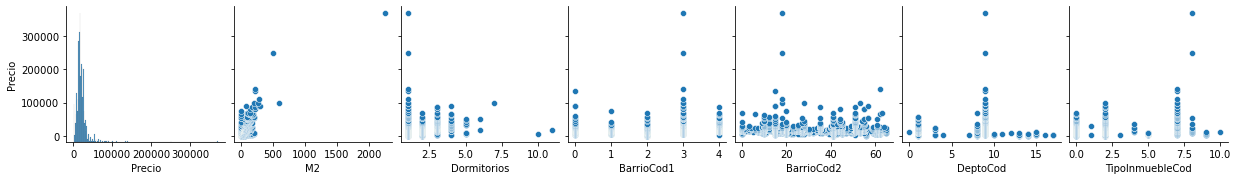

In [12]:
sns.pairplot(data,y_vars="Precio")

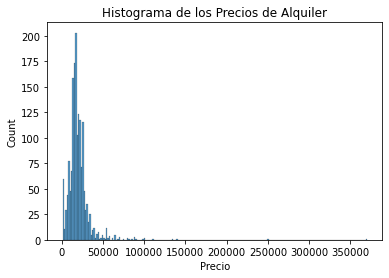

In [13]:
sns.histplot(data["Precio"]).set_title("Histograma de los Precios de Alquiler")
plt.show()

In [14]:
X = np.array(data.loc[:,["M2","BarrioCod1","BarrioCod2","Dormitorios","TipoInmuebleCod","DeptoCod"]])

In [15]:
y = np.array(data["Precio"])

### Regresión lineal clásica

In [16]:
reg = LinearRegression().fit(X, y)

In [17]:
reg.score(X, y)

0.5896546711179318

In [18]:
reg.coef_

array([ 181.62738265, 1181.9374835 ,  -16.13198229,  148.18694872,
        448.20290876,  258.461201  ])

<AxesSubplot:>

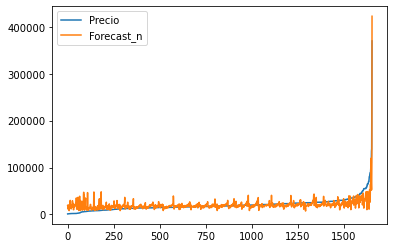

In [19]:
y_predict = reg.predict(X)
pd.DataFrame({"Precio":y,"Forecast_n":y_predict}).plot()

Hay un problema en los precios de los alquileres altos y bajos que el modelo no llega a captar. Esto puede deberse a características que no están en el básico de las publicaciones (años de aniguedad, contratos temporales, comodidas, etc). Una solución sería poner una dummy para los precios bajos y altos definiendo un umbral.

<AxesSubplot:xlabel='residuos', ylabel='Precio'>

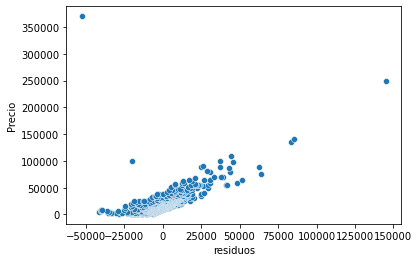

In [20]:
prediccion = pd.DataFrame({"Precio":y,"Forecast":y_predict})
prediccion["residuos"] = prediccion["Precio"] - prediccion["Forecast"]
sns.scatterplot(x=prediccion["residuos"],y=prediccion["Precio"])

### Regresión cuadrática 

In [21]:
X_scale = StandardScaler().fit_transform(X)

In [22]:
poly_x = PolynomialFeatures(degree=2)

In [23]:
X_scale2 = poly_x.fit_transform(X_scale)

In [24]:
reg_pol = LinearRegression()
reg_pol = reg_pol.fit(X_scale2,y)

In [25]:
reg_pol.score(X_scale2,y)

0.7098776289719639

El R cuadrado se incrementa notablemente.  Pero puede haber un problema de overfitting

In [26]:
reg_pol = LinearRegression()
features = []
scores = []
for i in range(1,X_scale2.shape[1]):
    score = regresiones_polinomiales(reg_pol,i,X_scale2,y)
    features += list(np.repeat(i,len(score)))
    scores += score

In [27]:
Features = pd.DataFrame({"Features":features,"Scores":scores})

In [28]:
mean_Features= Features.groupby("Features").mean()
median_Features= Features.groupby("Features").median()
min_Features= Features.groupby("Features").min()


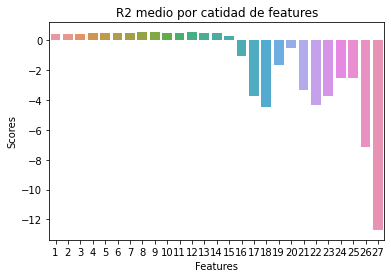

In [29]:
fig =sns.barplot(data = mean_Features,y="Scores",x=mean_Features.index)
fig.set_title("R2 medio por catidad de features")
plt.show()

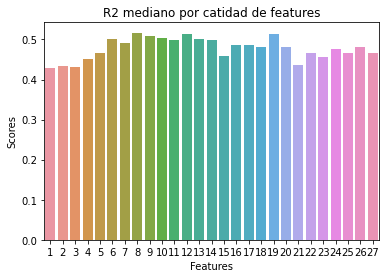

In [30]:
fig =sns.barplot(data = median_Features,y="Scores",x=median_Features.index)
fig.set_title("R2 mediano por catidad de features")
plt.show()

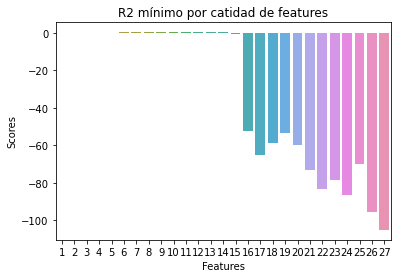

In [31]:
fig =sns.barplot(data = min_Features,y="Scores",x=min_Features.index)
fig.set_title("R2 mínimo por catidad de features")
plt.show()

In [32]:
mean_Features.sort_values("Scores",ascending=False).iloc[:4,:]

,Scores
Features,
12,0.531712
9,0.527485
8,0.527033
10,0.511017


In [33]:
median_Features.sort_values("Scores",ascending=False).iloc[:4,:]

,Scores
Features,
8,0.516759
12,0.514500
19,0.513337
9,0.508183


Hay que poner a competir los modelos con 11,10,8,9 y 13 features. Los primeros en el ranking en mediana y media.

In [34]:
sample,features,score = regresiones_polinomiales(reg_pol,[8,9,10,11,13],X_scale2,y)

In [35]:
Features = pd.DataFrame({"Sample":sample,"Features":features,"Scores":score}).set_index("Sample")

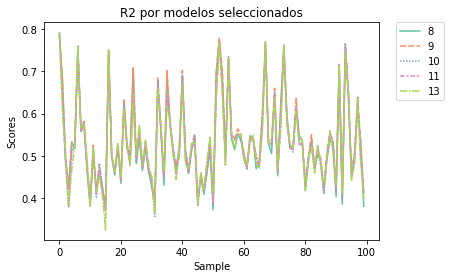

In [36]:
palette = sns.color_palette("Set2",5)
fig = sns.lineplot(data=Features,x="Sample",y="Scores",hue="Features",style="Features",palette=palette)
fig.set_title("R2 por modelos seleccionados")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Los modelos son bastante parejos en desempeño gráficamente.

In [37]:
Features.groupby("Features").mean()

,Scores
Features,
8,0.533471
9,0.541170
10,0.533364
11,0.532224
13,0.531245


In [38]:
Features.groupby("Features").median()

,Scores
Features,
8,0.515658
9,0.526071
10,0.519421
11,0.518735
13,0.519261


In [39]:
Features.groupby("Features").std()

,Scores
Features,
8,0.102494
9,0.101682
10,0.100535
11,0.097851
13,0.098240


El mejor modelo seria el que tiene 9 características.

In [40]:
reg_pol = LinearRegression()

In [41]:
selector = RFE(reg_pol, n_features_to_select=9, step=1)
selector = selector.fit(X_scale2, y)

In [42]:
X_scale2_best = X_scale2[:,selector.support_]

In [43]:
x_selected_polinomio = selector.support_

In [44]:
reg_pol_best = LinearRegression().fit(X_scale2_best, y)

In [45]:
reg_pol_best.score(X_scale2_best,y)

0.6471570692655101

El modelo mejora respecto al lineal

<AxesSubplot:>

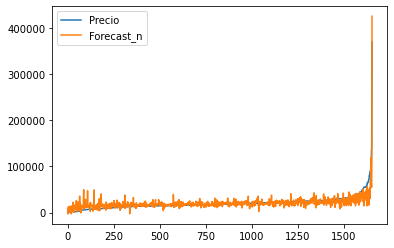

In [46]:
y_predict = reg_pol_best.predict(X_scale2_best)
pd.DataFrame({"Precio":y,"Forecast_n":y_predict}).plot()

<AxesSubplot:xlabel='residuos', ylabel='Precio'>

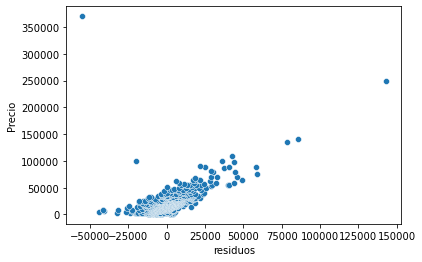

In [47]:
prediccion = pd.DataFrame({"Precio":y,"Forecast":y_predict})
prediccion["residuos"] = prediccion["Precio"] - prediccion["Forecast"]
sns.scatterplot(x=prediccion["residuos"],y=prediccion["Precio"])

Mejora bastante la correlación entre los precios y los residuos del modelo.

### Regresiones lineales con métodos de regularización

#### Ridge

Uno de los modelos de regularización. Se utiliza k-fold cross validation para obtener el mejor alpha que penalizan la suma cuadrada de los betas. Se arma un indicador de posibles alphas y se los pasa al algoritmo para que revalué con los k-fold y asegurarnos de que sea el óptimo. Por último, se compara con el modelo de regresión lineal por cross validation.

In [48]:
alphas = np.linspace(start=0,stop=300,num=600)[1:len(list(np.linspace(start=0,stop=300,num=600)))]

In [49]:
ridge_mod = RidgeCV(cv=5,normalize=True,alphas = alphas)

In [50]:
alpha_selected_first = ridge_mod.fit(X_scale2,y).alpha_

In [51]:
ridge = Ridge(alpha=alpha_selected_first,normalize=True)

In [52]:
features = []
scores = []
for i in range(1,X_scale2.shape[1]):
    score = regresiones_polinomiales(ridge,i,X_scale2,y)
    features += list(np.repeat(i,len(score)))
    scores += score


In [53]:
Features = pd.DataFrame({"Features":features,"Scores":scores})

In [54]:
mean_Features= Features.groupby("Features").mean()
median_Features= Features.groupby("Features").median()
min_Features= Features.groupby("Features").min()

In [55]:
mean_Features.sort_values("Scores",ascending=False)[:4]

,Scores
Features,
12,0.248563
13,0.243507
5,0.239227
10,0.237968


In [56]:
median_Features.sort_values("Scores",ascending=False)[:4]

,Scores
Features,
20,0.156768
17,0.155263
18,0.154104
13,0.152242


In [57]:
min_Features.sort_values("Scores",ascending=False)[:9]

,Scores
Features,
13,0.082508
18,0.082444
15,0.075380
1,0.063935
5,0.063432
6,0.063276
11,0.056464
10,0.050554
9,0.050285


El de 18 parece ser el mejor. Se estima de 9 y 18.

In [58]:
selector = RFE(ridge, n_features_to_select=18, step=1)
selector = selector.fit(X_scale2, y)

In [59]:
ridge_mod = RidgeCV(cv=50,normalize=True,alphas=alphas).fit(X_scale2[:,selector.support_], y)

In [60]:
x_selected_ridge = selector.support_

In [61]:
ridge_mod.score(X_scale2[:,selector.support_], y)

0.5962218664802242

In [62]:
alpha_selected_ridge = ridge_mod.alpha_

Tiene menos score, pero es evidente que tiene que suceder, ya que el modelo lineal es el que minimiza los valores dentro de la muestra. Para ponerlos a competir hay que hacer cross validation. Debemos seleccionar el alpha con este método también

In [63]:
score_polinomio = []
score_ridge = []
sample = []
for i in range(0,100):
    train_X, val_X, train_y, val_y = train_test_split(X_scale2, y,train_size=0.8)
    ridge = Ridge(alpha=alpha_selected_ridge).fit(train_X[:,x_selected_ridge],train_y)
    score_ridge.append(ridge.score(val_X[:,x_selected_ridge],val_y))
    pol = LinearRegression().fit(train_X[:,x_selected_polinomio],train_y)
    score_polinomio.append(pol.score(val_X[:,x_selected_polinomio],val_y))


<AxesSubplot:>

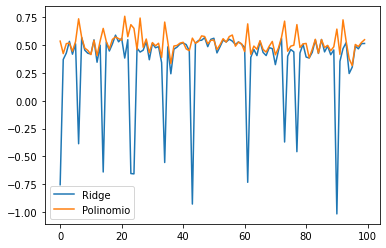

In [64]:
prediccion_ridge = pd.DataFrame({"Ridge": score_ridge, "Polinomio":score_polinomio})
prediccion_ridge.plot()

El comportamiento del ridge esta muy por debajo. Debe haber un problema de overfitting. Se usa la mismas features que el modelo lineal

In [66]:
ridge_mod = RidgeCV(cv=50,normalize=True,alphas=alphas).fit(X_scale2[:,x_selected_polinomio], y)

In [67]:
alpha_selected_ridge = ridge_mod.alpha_

In [68]:
ridge_mod.score(X_scale2[:,x_selected_polinomio], y)

0.5576386995271605

In [69]:
score_polinomio = []
score_ridge = []
sample = []
for i in range(0,100):
    train_X, val_X, train_y, val_y = train_test_split(X_scale2, y,train_size=0.8)
    ridge = Ridge(alpha=alpha_selected_ridge).fit(train_X[:,x_selected_polinomio],train_y)
    score_ridge.append(ridge.score(val_X[:,x_selected_polinomio],val_y))
    pol = LinearRegression().fit(train_X[:,x_selected_polinomio],train_y)
    score_polinomio.append(pol.score(val_X[:,x_selected_polinomio],val_y))

<AxesSubplot:>

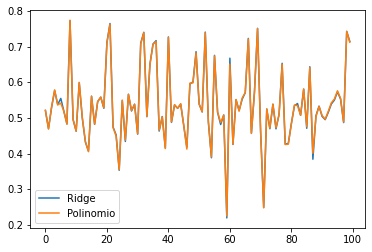

In [70]:
prediccion_ridge = pd.DataFrame({"Ridge": score_ridge, "Polinomio":score_polinomio})
prediccion_ridge.plot()

El desempeño de los modelos es bastante parecido.

In [71]:
prediccion_ridge.describe()

,Ridge,Polinomio
count,100.000000,100.000000
mean,0.538373,0.538379
std,0.104675,0.103575
min,0.219587,0.225081
25%,0.480862,0.481597
50%,0.526008,0.526500
75%,0.573532,0.573470
max,0.773338,0.774364


#### Lasso

Uno de los modelos de regularización. Se utiliza k-fold cross validation para obtener el mejor alpha que penalizan la suma absoluta de los betas. Se arma un indicador de posibles alphas y se los pasa al algoritmo para que revalué con los k-fold y asegurarnos de que sea el óptimo. Por último, se compara con el modelo de regresión lineal por cross validation.

In [72]:
lasso_mod = LassoCV(cv=50,alphas=alphas,random_state=0,normalize=True).fit(X_scale2[:,x_selected_polinomio], y)

In [73]:
alpha_selected_lasso = lasso_mod.alpha_

In [74]:
alpha_selected_lasso

0.5008347245409015

In [75]:
lasso_mod.score(X_scale2[:,x_selected_polinomio],y)

0.6461150911903137

El alpha no cambió. Se realizan estimaciones con el alpha y el modelo de regresión lineal por CV

In [89]:
score_polinomio = []
score_ridge = []
score_lasso = []
sample = []
for i in range(0,100):
    train_X, val_X, train_y, val_y = train_test_split(X_scale2, y,train_size=0.8)
    ridge = Ridge(alpha=alpha_selected_ridge).fit(train_X[:,x_selected_polinomio],train_y)
    score_ridge.append(ridge.score(val_X[:,x_selected_polinomio],val_y))
    pol = LinearRegression().fit(train_X[:,x_selected_polinomio],train_y)
    score_polinomio.append(pol.score(val_X[:,x_selected_polinomio],val_y))
    lasso = Lasso(alpha=alpha_selected_lasso).fit(train_X[:,x_selected_polinomio],train_y)
    score_lasso.append(lasso.score(val_X[:,x_selected_polinomio],val_y))
    

<AxesSubplot:>

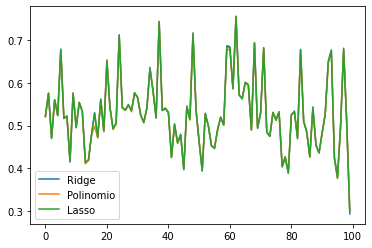

In [86]:
prediccion = pd.DataFrame({"Ridge": score_ridge, "Polinomio":score_polinomio, "Lasso":score_lasso})
prediccion.plot()

In [87]:
prediccion.describe()

,Ridge,Polinomio,Lasso
count,100.000000,100.000000,100.000000
mean,0.529023,0.528613,0.528996
std,0.086005,0.084900,0.085075
min,0.293817,0.300113,0.299735
25%,0.481314,0.481908,0.482124
50%,0.524000,0.522862,0.524307
75%,0.561965,0.561593,0.561806
max,0.755412,0.754743,0.754796


Los modelos tienene un desempeño similar. Sin embargo, Lasso tiene una mayor media y mediana.